In [27]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import *

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

#from sklearn.inspection import permutation_importance

from typing import List, Dict, Tuple
from sklearn.base import BaseEstimator
from IPython.display import display, Markdown


## Objective

Reproduce the metabolomics study by  [Gall et al. (2019)](https://link.springer.com/article/10.1007/s11306-019-1612-4) using the MTBL92 plasma lipidomics dataset.  

1. **Classification**  
   - Apply six* binary classifiers from scikit-learn to distinguish pre- vs. post-neoadjuvant chemotherapy samples.  
2. **Performance Evaluation**  
   - Use cross-validation to compute accuracy, sensitivity, specificity, and AUC for each model.  
3. **Feature Selection**  
   - Choose any three classifiers and extract the three most important lipid features from each.  
4. **Biological Interpretation**  
   - Contextualize the selected metabolites  in terms of chemotherapy-induced perturbations to membrane integrity, apoptosis signaling, and energy metabolism.  


### Dataset Overview

**Clinical variables**  
- **Class**: 1 = pre-chemo, 0 = post-chemo  
- **Menopause**: 1 = pre-menopausal, 2 = post-menopausal  
- **ER**: 0 = ER–, 1 = ER+  
- **Grade**: tumor grade (1 = well, 2 = moderate, 3 = poor)  
- **Her2**: 0 = Her2–, 1 = Her2+ (2 = equivocal)  
- **N-stage**: AJCC lymph-node stage (0–3)  
- **T-stage**: AJCC tumor stage (0–4)  

---

**Lipid features (M1–M138)**  

| Columns   | Lipid ID Range                                 | Class                          |
|:----------|:-----------------------------------------------|:-------------------------------|
| M1–M2     | Cer(d18:1/17:0) – Cer(d18:1/22:6)               | Ceramide                       |
| M3–M12    | LysoPC(14:0) – LysoPC(20:4)                     | Lysophosphatidylcholine        |
| M13–M14   | LysoPE(18:1) – LysoPE(18:2)                     | Lysophosphatidylethanolamine   |
| M15–M59   | PC(30:0) – PC(38:7)                             | Phosphatidylcholine            |
| M60–M68   | PE(36:0) – PE(40:6)                             | Phosphatidylethanolamine       |
| M69–M86   | SM(d18:1/14:0) – SM(d18:1/25:2)                 | Sphingomyelin                  |
| M87–M138  | TG(14:0/16:0/16:0) – TG(58:6)                   | Triacylglycerol                |


In [3]:
df = pd.read_excel('../data/MTBLS92_preprocessed.xlsx')

Let's check the overview.

In [4]:
df.info(show_counts=True, verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253 entries, 0 to 252
Data columns (total 146 columns):
 #    Column     Non-Null Count  Dtype  
---   ------     --------------  -----  
 0    Class      253 non-null    int64  
 1    Menopause  253 non-null    int64  
 2    ER         253 non-null    int64  
 3    Grade      253 non-null    float64
 4    Her2       253 non-null    int64  
 5    N-stage    253 non-null    int64  
 6    T-stage    253 non-null    int64  
 7    Series     253 non-null    object 
 8    M1         253 non-null    float64
 9    M2         253 non-null    float64
 10   M3         253 non-null    float64
 11   M4         253 non-null    float64
 12   M5         253 non-null    float64
 13   M6         253 non-null    float64
 14   M7         253 non-null    float64
 15   M8         253 non-null    float64
 16   M9         253 non-null    float64
 17   M10        253 non-null    float64
 18   M11        253 non-null    float64
 19   M12        253 non-null    

253 values of class label (0.0 or 1.0). No NaN to clean up here because we already did that in a separate notebook.

Let's take a peek.


In [5]:
df.head(20)

,Class,Menopause,ER,Grade,Her2,N-stage,T-stage,Series,M1,M2,...,M129,M130,M131,M132,M133,M134,M135,M136,M137,M138
0,0,2,1,2.0,0,0,3,discovery,0.726960,58.899051,...,9.963454,3.976321,6.033208,20.737836,39.518648,4.372182,15.099900,15.520762,29.760339,2.890181
1,0,2,0,2.0,0,1,2,discovery,0.608255,66.045391,...,12.106535,5.006672,7.112918,17.030243,14.513175,2.961922,16.137018,13.461109,11.717635,1.213627
2,0,2,1,2.0,0,2,5,discovery,0.753607,46.106390,...,12.406024,5.279220,3.238246,23.586563,13.248736,4.775705,16.418746,18.986196,25.661178,1.724701
3,0,2,1,1.0,0,1,2,discovery,0.967593,60.123294,...,6.644769,4.359540,2.003790,14.733730,6.092037,2.101370,10.146233,8.364284,13.960879,0.816202
4,0,2,1,2.0,0,1,2,discovery,0.872226,60.546387,...,6.066591,4.565057,3.456530,15.371234,6.091531,1.318297,7.047676,6.197168,6.994256,0.754510
5,0,1,1,2.0,0,1,2,discovery,1.235626,57.352100,...,10.442485,5.173761,2.649353,17.887483,7.848590,1.785468,15.681046,12.719544,15.228005,1.593819
6,0,2,1,2.0,0,0,2,discovery,0.579069,50.791284,...,8.196255,10.647111,4.055241,21.942372,10.797598,4.237617,14.503946,14.726594,26.439269,1.898444
7,0,2,1,2.0,0,1,5,discovery,0.824576,56.481689,...,13.943848,4.961841,5.163851,26.530701,12.926935,1.345866,13.505289,11.108142,5.084578,1.836360
8,0,1,1,3.0,0,1,2,discovery,0.572180,60.720973,...,5.389345,5.237880,2.010686,7.305390,3.134031,1.091911,7.427189,5.925728,8.543335,0.763399
9,0,2,0,3.0,0,1,2,discovery,0.700200,60.543203,...,6.672021,4.624057,2.559283,13.113349,4.596324,1.906155,12.725536,10.714583,8.823328,0.971545


Hmm, the 'Series' column looks sus. Let's check if it has values other than 'discovery'.

In [6]:
df['Series'].value_counts()

Series
discovery    253
Name: count, dtype: int64

So no other values other than 'discovery', therefore we are going to drop the whole column.

In [7]:
df = df.drop(['Series'], axis=1)

In [8]:
df.head(5)

,Class,Menopause,ER,Grade,Her2,N-stage,T-stage,M1,M2,M3,...,M129,M130,M131,M132,M133,M134,M135,M136,M137,M138
0,0,2,1,2.0,0,0,3,0.726960,58.899051,1.759911,...,9.963454,3.976321,6.033208,20.737836,39.518648,4.372182,15.099900,15.520762,29.760339,2.890181
1,0,2,0,2.0,0,1,2,0.608255,66.045391,2.665832,...,12.106535,5.006672,7.112918,17.030243,14.513175,2.961922,16.137018,13.461109,11.717635,1.213627
2,0,2,1,2.0,0,2,5,0.753607,46.106390,1.946525,...,12.406024,5.279220,3.238246,23.586563,13.248736,4.775705,16.418746,18.986196,25.661178,1.724701
3,0,2,1,1.0,0,1,2,0.967593,60.123294,2.085995,...,6.644769,4.359540,2.003790,14.733730,6.092037,2.101370,10.146233,8.364284,13.960879,0.816202
4,0,2,1,2.0,0,1,2,0.872226,60.546387,2.021663,...,6.066591,4.565057,3.456530,15.371234,6.091531,1.318297,7.047676,6.197168,6.994256,0.754510


okay, looks good, let's begin with our tasks: 

1. Split Dataset
2. Build a Preprocessing Pipeline to Scale/Impute Values
3. Evaluate 7 Machine Learning Models Using Scikit-Learn:
    - Build a paramater grid dict for each classifier.
    - Build GridSearchCV pipelines
    - Evaluate Models
4. Extract 3 most important features for 3 of the resulting models

In [9]:
X = df.drop(['Class'], axis=1)
y = df['Class']

# Since we are replicating the results of the paper, we will use the same train/test split etc as in the paper.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=11, stratify=y)

We will now Encode our categorical variables using One hot encoding and Scale our numerical variables using Standard Scaler.

In [10]:
#list of categorical features
cat_features = ['Menopause', 'ER', 'Grade', 'Her2', 'N-stage', 'T-stage']

#list of continuous features
num_features = [c for c in X_train.columns if c not in cat_features]

# now we start building the 'preprocessing' pipeline

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')),
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, num_features),
    ('cat', categorical_pipeline, cat_features),
])


Now that our features are encoded/scaled and imputed(if needed), we move on to defining a hyperparameters grid for our classifiers. 

In [11]:
param_grid = {
    'Random Forest Classifier': {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 10],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'Decision Tree Classifier': {
        'max_depth': [None, 5, 10],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'K-Nearest Neighbors Classifier': {
        'n_neighbors': [3, 5, 7],
        'p': [1, 2]
    },
    'Support Vector Classifier': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    },
    'Gradient Boosting Classifier': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.6, 0.8, 1.0],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'Neural Network Classifier': {
        'hidden_layer_sizes': [(50,), (100,), (50, 50)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam', 'sgd'],
        'alpha': [0.0001, 0.001], 
        'learning_rate_init': [0.001, 0.01]
    }   

}

In [13]:
# prepending 'classifier__' to each parameter name in the grid
# this is necessary because the parameters in the pipeline are prefixed with 'classifier__'
fixed_param_grid = {}

for model_name, grid in param_grid.items():

    fixed_inner = {}
    
    for param, values in grid.items():
        new_key = f"classifier__{param}"
        fixed_inner[new_key] = values

    fixed_param_grid[model_name] = fixed_inner


In [14]:
# list of classifiers to be used
# each classifier is a tuple of (classifier, name)
classifiers = [
    (RandomForestClassifier(random_state=11), "Random Forest Classifier"),
    (DecisionTreeClassifier(random_state=11), "Decision Tree Classifier"),
    (KNeighborsClassifier(), "K-Nearest Neighbors Classifier"),
    (GaussianNB(), "Naive Bayes Classifier"),
    (SVC(probability=True, random_state=11), "Support Vector Classifier"),
    (GradientBoostingClassifier(random_state=11), "Gradient Boosting Classifier"),
    (MLPClassifier( max_iter=500, random_state=11), "Neural Network Classifier")
]


classification_models = []
for clf, name in classifiers:
    #building pipeline for each classifier.
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', clf)
    ])
    # setting up the grid search for each classifier using our hyperparameter grid
    gs = GridSearchCV(
        pipe,
        fixed_param_grid.get(name, {}),
        cv=5,
        n_jobs=-1
    )
    classification_models.append((gs, name))

In [15]:
#evaluate_models function
def evaluate_models(models):
    results_df = pd.DataFrame(
        columns=['Best Parameters', 'Average Accuracy (5 Folds Cross-Val)',
                 'Precision', 'Recall', 'F1 Score']
    )

    for model, model_name in models:
        print(f'>>> Training {model_name}...')
        model.fit(X_train, y_train)

        best_params = model.best_params_
        best_model = model.best_estimator_

        y_pred = best_model.predict(X_test)

        metrics = {
            'Best Parameters': best_params,
            'Average Accuracy (5 Folds Cross-Val)': round(model.best_score_, 3),
            'Precision': round(precision_score(y_test, y_pred, average='macro'), 3),
            'Recall': round(recall_score(y_test, y_pred, average='macro'),3),
            'F1 Score': round(f1_score(y_test, y_pred, average='macro'), 3)
        }

        results_df.loc[model_name] = metrics 
        
    return results_df

Now that everything is set, let's fit and evaluate some models!

In [16]:
model_results = evaluate_models(classification_models)

>>> Training Random Forest Classifier...
>>> Training Decision Tree Classifier...
>>> Training K-Nearest Neighbors Classifier...
>>> Training Naive Bayes Classifier...
>>> Training Support Vector Classifier...
>>> Training Gradient Boosting Classifier...
>>> Training Neural Network Classifier...


In [17]:
pd.set_option('display.max_colwidth', None)
model_results.sort_values(by='Average Accuracy (5 Folds Cross-Val)', ascending=False) 

,Best Parameters,Average Accuracy (5 Folds Cross-Val),Precision,Recall,F1 Score
Neural Network Classifier,"{'classifier__activation': 'relu', 'classifier__alpha': 0.0001, 'classifier__hidden_layer_sizes': (50,), 'classifier__learning_rate_init': 0.01, 'classifier__solver': 'sgd'}",0.763,0.710,0.707,0.708
Support Vector Classifier,"{'classifier__C': 1, 'classifier__gamma': 'scale', 'classifier__kernel': 'linear'}",0.734,0.689,0.692,0.689
Gradient Boosting Classifier,"{'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 100, 'classifier__subsample': 0.6}",0.716,0.664,0.650,0.651
Naive Bayes Classifier,{},0.686,0.585,0.578,0.576
Random Forest Classifier,"{'classifier__max_depth': 3, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}",0.674,0.627,0.610,0.606
K-Nearest Neighbors Classifier,"{'classifier__n_neighbors': 3, 'classifier__p': 2}",0.621,0.589,0.564,0.545
Decision Tree Classifier,"{'classifier__max_depth': None, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2}",0.591,0.586,0.584,0.584


Moving on towards making a confusion matrix.

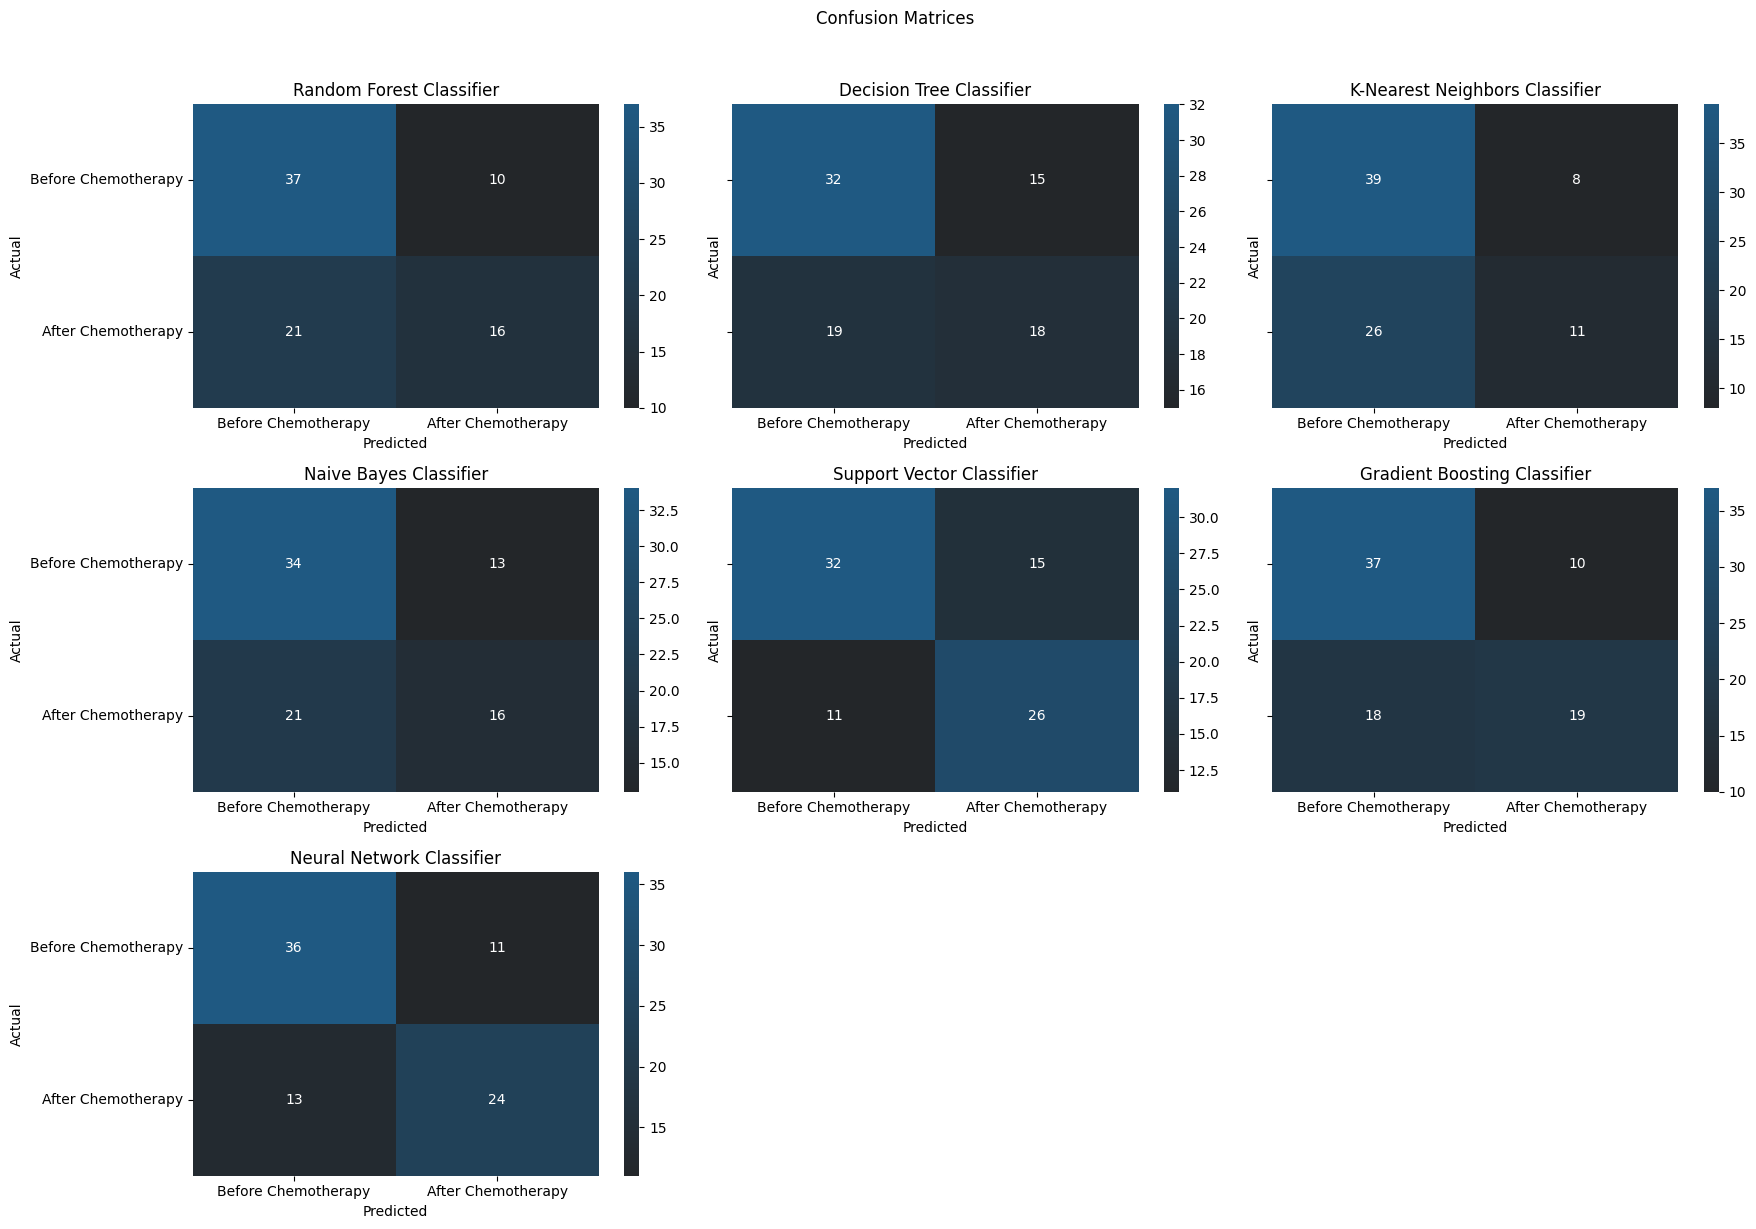

In [18]:
#getting predictions for each best model
preds = [gs.best_estimator_.predict(X_test) for gs, _ in classification_models]

#extracting the names of the models for plotting
model_names = [name for _, name in classification_models]


class_names = ["Before Chemotherapy", "After Chemotherapy"]

# Plotting confusion matrices for each model
n_models = len(classification_models)
n_cols = 3
n_rows = math.ceil(n_models / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 4*n_rows), sharey=True)
axes = axes.flatten()

for i, (y_pred, name) in enumerate(zip(preds, model_names)):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(
        cm, annot=True, fmt="d",
        xticklabels=class_names,
        yticklabels=class_names,
        cmap=sns.dark_palette("#1f5982", as_cmap=True),
        ax=axes[i]
    )
    axes[i].set_title(name)
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")


for j in range(n_models, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Confusion Matrices", y=1.02)
plt.tight_layout()
plt.show()


Let's take a look at ROC/AUC as well. 

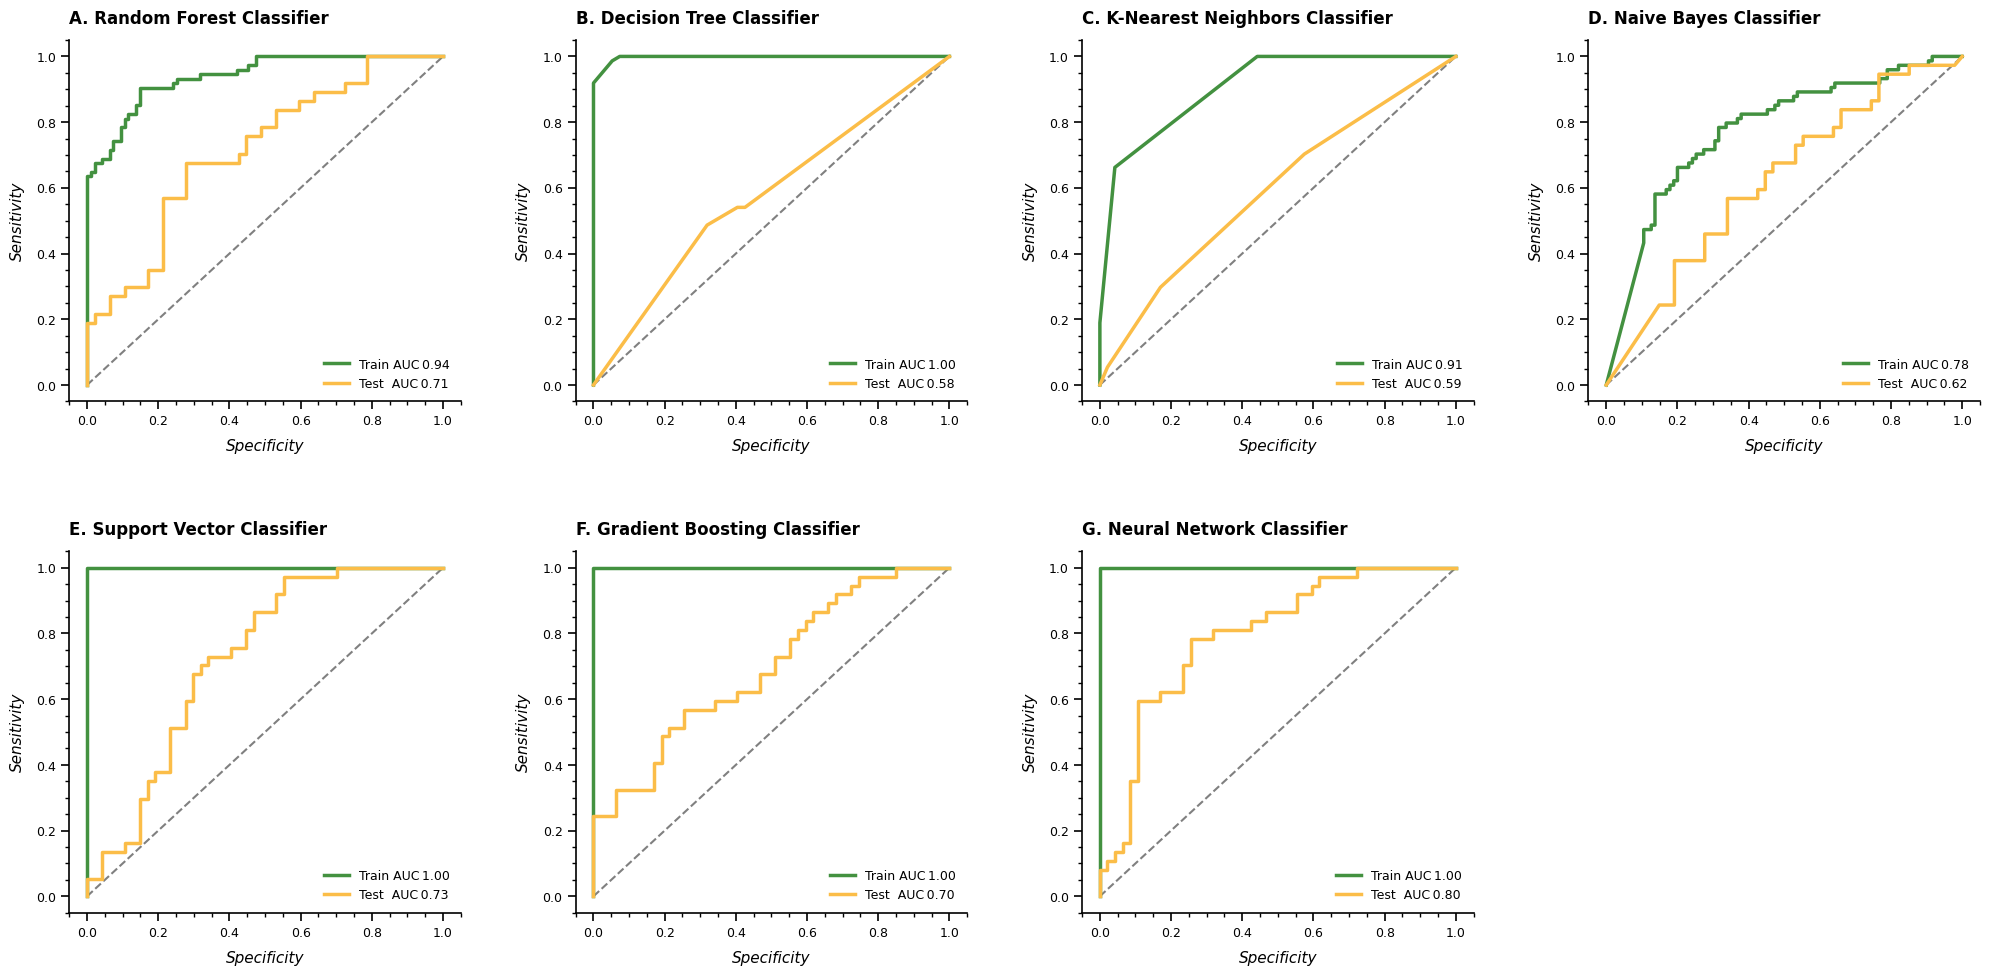

In [29]:
n_models = len(classification_models)
n_cols = 4
n_rows = int(np.ceil(n_models / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows), dpi=100)
axes = axes.flatten()

#Panel labels A, B, C, …
panel_labels = [chr(ord('A') + i) for i in range(n_models)]

for i, ((gs, name), label) in enumerate(zip(classification_models, panel_labels)):
    ax = axes[i]
    pipe = gs.best_estimator_
    pos = pipe.classes_[1]

    #Get scores
    try:
        y_tr_score = pipe.predict_proba(X_train)[:, 1]
        y_te_score = pipe.predict_proba(X_test)[:, 1]
    except AttributeError:
        y_tr_score = pipe.decision_function(X_train)
        y_te_score = pipe.decision_function(X_test)

    #Compute ROC + AUC
    fpr_tr, tpr_tr, _ = roc_curve(y_train, y_tr_score, pos_label=pos)
    fpr_te, tpr_te, _ = roc_curve(y_test,  y_te_score,  pos_label=pos)
    auc_tr = auc(fpr_tr, tpr_tr)
    auc_te = auc(fpr_te, tpr_te)

    #Plot
    ax.plot(fpr_tr, tpr_tr, color='#439140', lw=2.5, label=f"Train AUC {auc_tr:.2f}", zorder=3)
    ax.plot(fpr_te, tpr_te, color='#fbbd48', lw=2.5, label=f"Test  AUC {auc_te:.2f}",  zorder=3)
    ax.plot([0,1], [0,1], '--', lw=1.5, color='gray', zorder=1)

    #Styling
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)

    ax.set_facecolor('white')
    ax.set_title(f"{label}. {name}", loc='left', fontweight='bold', fontsize=12, pad=12)
    ax.set_xlabel("Specificity", fontsize=11, labelpad=8, fontstyle='italic')
    ax.set_ylabel("Sensitivity", fontsize=11, labelpad=8, fontstyle='italic')

    # Major ticks
    ax.tick_params(axis='both', which='major', labelsize=9, width=1.2, length=6, direction='out')
    # Minor ticks
    ax.xaxis.set_minor_locator(AutoMinorLocator(4))
    ax.yaxis.set_minor_locator(AutoMinorLocator(4))
    ax.tick_params(axis='both', which='minor', labelsize=0, width=1.0, length=3, direction='out')

    # Thicken 'spines'
    for spine in ['left', 'bottom']:
        ax.spines[spine].set_linewidth(1.2)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Legend
    ax.legend(frameon=False, fontsize=9, loc='lower right')

#Remove any unused subplots
for j in range(n_models, n_rows * n_cols):
    fig.delaxes(axes[j])

# Layout adjustments
plt.tight_layout(w_pad=4, h_pad=5)
plt.subplots_adjust(top=0.94)
plt.show()


Let's just pick all the tree based classifers we used and extract top 3 features from them.

In [ ]:
#Extract & clean feature names from ColumnTransformer
def extract_feature_names(preprocessor) -> List[str]:
    """
    Given a fitted ColumnTransformer, return the flattened list of output feature names.
    """
    raw_names = preprocessor.get_feature_names_out()
    return [name.split("__", 1)[1] for name in raw_names]

#Build a DataFrame of top_n importances for one model
def get_model_importances(gs: GridSearchCV,top_n: int = 10) -> pd.DataFrame:
    """
    From a fitted GridSearchCV whose best_estimator_
    contains a tree-based classifier, return a DataFrame
    of the top_n features by importance.
    """
    pipe: Pipeline = gs.best_estimator_
    clf: BaseEstimator = pipe.named_steps['classifier']
    
    if not hasattr(clf, "feature_importances_"):
        raise ValueError(f"{clf.__class__.__name__} has no feature_importances_")
    
    feat_names = extract_feature_names(pipe.named_steps['preprocessor'])
    importances = clf.feature_importances_
    
    df = (
        pd.DataFrame({'feature': feat_names, 'importance': importances})
          .sort_values('importance', ascending=False)
          .head(top_n)
          .reset_index(drop=True)
    )
    df['rank'] = df['importance'].rank(ascending=False, method='first').astype(int)
    return df[['rank', 'feature', 'importance']]

#Loop over selected models to gather their top_n importances
def get_top_features_dfs(models: List[Tuple[GridSearchCV, str]], model_indices: List[int],top_n: int = 10) -> Dict[str, pd.DataFrame]:
    """
    Returns a dict mapping model names to their top_n feature importances DataFrame.
    Skips any model without .feature_importances_.
    """
    dfs: Dict[str, pd.DataFrame] = {}
    for idx in model_indices:
        gs, name = models[idx]
        try:
            dfs[name] = get_model_importances(gs, top_n)
        except ValueError:
            # not tree-based—skip
            continue
    return dfs

#print each DataFrame as a Markdown table
def pretty_print_feature_importances(dfs: Dict[str, pd.DataFrame]):
    """
    Given a dict of {model_name: DataFrame(rank, feature, importance)},
    render each as a Markdown table with 3-decimal importances.
    """
    for model_name, df in dfs.items():
        display(Markdown(f"**Top {len(df)} Features for {model_name}**"))
        # Format importance to 3 decimals
        md = df.to_markdown(index=False, floatfmt=".3f")
        display(Markdown(md))

top_feature_dfs = get_top_features_dfs(classification_models, [0, 1, 5], top_n=3)
pretty_print_feature_importances(top_feature_dfs)


**Top 3 Features for Random Forest Classifier**

|   rank | feature   |   importance |
|-------:|:----------|-------------:|
|      1 | M53       |        0.055 |
|      2 | M55       |        0.045 |
|      3 | M130      |        0.034 |

**Top 3 Features for Decision Tree Classifier**

|   rank | feature   |   importance |
|-------:|:----------|-------------:|
|      1 | M53       |        0.187 |
|      2 | M96       |        0.148 |
|      3 | M84       |        0.101 |

**Top 3 Features for Gradient Boosting Classifier**

|   rank | feature   |   importance |
|-------:|:----------|-------------:|
|      1 | M130      |        0.073 |
|      2 | M53       |        0.069 |
|      3 | M27       |        0.038 |

xxxxxxxxxxxxxxxxxxxxxxxx

In [39]:
peaks_df = pd.read_excel("../data/MTBLS92.xlsx", sheet_name="Peak")

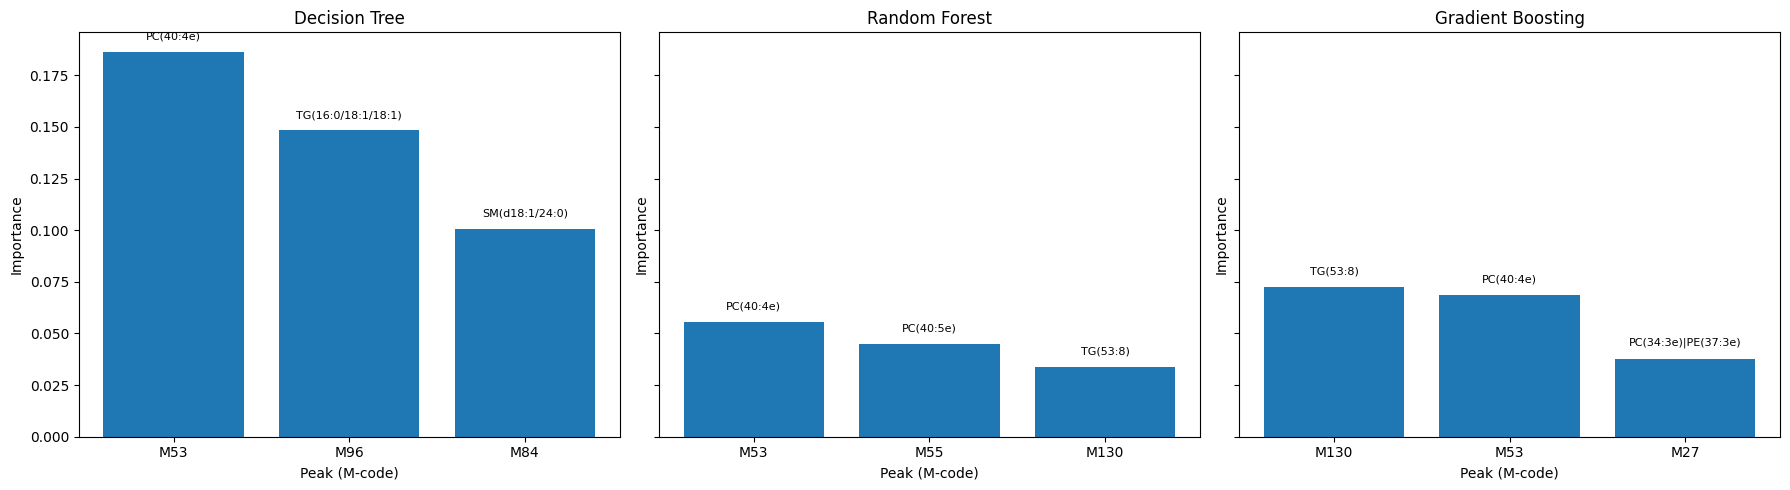

In [ ]:

peak_meta = (
    peaks_df[['Name','Label']]
      .rename(columns={'Name':'feature','Label':'annotation'})
)

# Extract top importances for each model
rf_gs = classification_models[0][0]  # Random Forest
dt_gs = classification_models[1][0]  # Decision Tree
gb_gs = classification_models[5][0]  # Gradient Boosting

top_n = 3
dt_imp = get_model_importances(dt_gs, top_n=top_n)
rf_imp = get_model_importances(rf_gs, top_n=top_n)
gb_imp = get_model_importances(gb_gs, top_n=top_n)

# Merge with annotations
dt_meta = dt_imp.merge(peak_meta, on='feature', how='left')
rf_meta = rf_imp.merge(peak_meta, on='feature', how='left')
gb_meta = gb_imp.merge(peak_meta, on='feature', how='left')

# Plot side-by-side bar charts
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for ax, (df, title) in zip(axes, [
    (dt_meta, "Decision Tree"),
    (rf_meta, "Random Forest"),
    (gb_meta, "Gradient Boosting")
]):
    top = df.nlargest(top_n, 'importance')
    bars = ax.bar(top['feature'], top['importance'])
    ax.set_title(title)
    ax.set_xlabel("Peak (M-code)")
    ax.set_ylabel("Importance")
    # annotate with chemical label
    for bar, ann in zip(bars, top['annotation']):
        ax.text(
            bar.get_x() + bar.get_width()/2,
            bar.get_height() + 0.005,
            ann,
            ha='center',
            va='bottom',
            rotation=0,
            fontsize=8
        )

plt.tight_layout()
plt.show()
